In [1]:
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()

'/usr/local/opt/apache-spark/libexec'

In [2]:
import pandas as pd
import random
import numpy as np

import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from sklearn.preprocessing import MinMaxScaler
from pyspark.sql.functions import udf, struct
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, StringType, ArrayType
from pyspark.sql import SQLContext
import time
import matplotlib.pyplot as plt
import seaborn as sns

from utils import tools, data_preprocessing
from eALS import eALS
from ALS import ALS

In [3]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

conf = pyspark.SparkConf().set('spark.driver.host','127.0.0.1')
sc = pyspark.SparkContext(master='local', appName='myAppName',conf=conf)

spark = SparkSession(sc)
sqlContext = SQLContext(sc)

In [4]:
def load_data(rows):
    data_path = "data/data_yelp.csv"

    data = data_preprocessing("data/yelp_rating.txt", data_path, rows=rows)

    rating_df = spark.read.format("csv")\
        .option("header", "true")\
        .option("inferSchema", "true")\
        .option("delimiter", ",")\
        .load(data_path)

    rating_rdd = rating_df.rdd

    # Input variables
    rating_list = rating_rdd.collect()

    # utils
    tool = tools(rating_list, data_path)
    R = tool.set_data_matrix()
    return R, data, rating_list

In [ ]:
data_path = "data/data_yelp.csv"
max_rows = 731669
percentage_data = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05]
time_perf_eALS_rdd = []
time_perf_eALS_df = []
score_perf_eALS_rdd = []
score_perf_eALS_df = []

for perc in percentage_data:
    R, data, rating_list = load_data(round(max_rows*perc))
    tool = tools(rating_list, data_path)
    
    MF_eALS = eALS(R)
    
    start = time.time()
    U_rdd, V_rdd = MF_eALS.fit_rdd(10, sc)
    end = time.time()
    time_perf_eALS_rdd.append(end - start)
    print(end - start)
    
    rmse_eALS_rdd = tool.rmse(U_rdd, V_rdd)
    score_perf_eALS_rdd.append(rmse_eALS_rdd)
    print(rmse_eALS_rdd)
    
    start = time.time()
    U_df, V_df = MF_eALS.fit_df(10, sc, spark, sqlContext)
    end = time.time()
    time_perf_eALS_df.append(end - start)
    print(end - start)
    
    rmse_eALS_df = tool.rmse(U_df, V_df)
    score_perf_eALS_df.append(rmse_eALS_df)
    print(rmse_eALS_df)
    
    print("Data %.3f%% done" %perc)
    

### 10 iteration with bigger datasets
14.401893138885498

2.6644268585361104

15.605443000793457

2.617139739481923

Data 0.005% done

49.539230823516846

2.643011757798002

56.279747009277344

2.70579753923311

Data 0.010% done

199.7611358165741

2.5336031939826107

201.57259583473206

2.5324046628654258

Data 0.020% done

368.5860240459442

2.3154901590613446

363.32819294929504

2.399199348745057

Data 0.030% done

3958.833958864212

2.263400144977772

4372.368039131165

2.167447795359282

Data 0.040% done

5398.275675773621

2.0757431153848236

5463.523674964905

2.023811971921003

Data 0.050% done

In [ ]:
max_rows = 731669
percentage_data = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05]
time_perf_ALS_rdd = []
time_perf_ALS_df = []
score_perf_ALS_rdd = []
score_perf_ALS_df = []
data_path = "data/data_yelp.csv"

for perc in percentage_data:
    R, data, rating_list = load_data(round(max_rows*perc))
    tool = tools(rating_list, data_path)
    
    MF_ALS = ALS(R, rating_list)
    
    start = time.time()
    U_rdd, V_rdd = MF_ALS.fit_rdd(10, sc)
    end = time.time()
    time_perf_ALS_rdd.append(end - start)
    print(end - start)
    
    rmse_ALS_rdd = tool.rmse(U_rdd, V_rdd.T)
    score_perf_ALS_rdd.append(rmse_ALS_rdd)
    print(rmse_ALS_rdd)
    
    start = time.time()
    U_df, V_df = MF_ALS.fit_df(10, sc, spark, sqlContext)
    end = time.time()
    time_perf_ALS_df.append(end - start)
    print(end - start)
    
    rmse_ALS_df = tool.rmse(U_df, V_df.T)
    score_perf_ALS_df.append(rmse_ALS_df)
    print(rmse_ALS_df)
    
    print("Data %.3f%% done" %perc)

### 10 iteration with bigger datasets
8.327862024307251

2.1350177002347586

9.569355964660645

2.1327777703517583

Data 0.005% done

24.746404886245728

2.782225989276042

28.812262773513794

2.922073119398629

Data 0.010% done

75.352130651474

3.2835495509804393

82.9613208770752

2.9965314373171537

Data 0.020% done

278.8325128555298

3.0586951451980138

288.56825590133667

3.0592273291213234

Data 0.030% done

982.1419711112976

2.7635457166697672

1028.788255929947

2.8484975407227098

Data 0.040% done

3331.251740217209

2.707991179060188

3232.3929619789124

2.638752219263093

Data 0.050% done

## Dataset size 10 iterations

In [42]:
time_perf_eALS_rdd = [14.40, 49.53, 199.76, 368.58, 3958.83, 5398.27]
time_perf_eALS_df = [15.6, 56.27, 201.57, 363.32, 4372.36, 5463.52]
score_perf_eALS_rdd = [2.66, 2.64, 2.53, 2.31, 2.26, 2.07]
score_perf_eALS_df = [2.61, 2.70, 2.53, 2.39, 2.16, 2.02]

time_perf_ALS_rdd = [8.32, 24.74, 75.35, 278.83, 982.14, 3331.25]
time_perf_ALS_df = [9.56, 28.81, 82.96, 288.56, 1028.78, 3232.39]
score_perf_ALS_rdd = [2.63, 2.78, 3.28, 3.05, 2.76, 2.70] 
score_perf_ALS_df = [2.63, 2.92, 2.99, 3.05, 2.84, 2.63]

In [43]:
percentage_data = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05]

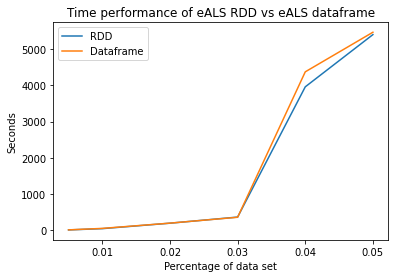

In [86]:
sns.lineplot(x=percentage_data, y=time_perf_eALS_rdd)
sns.lineplot(x=percentage_data, y=time_perf_eALS_df)
plt.title('Time performance of eALS RDD vs eALS dataframe')
plt.ylabel('Seconds')
plt.xlabel('Percentage of data set')
plt.legend(('RDD', 'Dataframe'))
plt.savefig('graphs/time_eALS_RDD_DF.png')
plt.show()

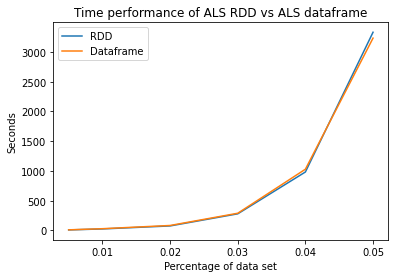

In [87]:
sns.lineplot(x=percentage_data, y=time_perf_ALS_rdd)
sns.lineplot(x=percentage_data, y=time_perf_ALS_df)
plt.title('Time performance of ALS RDD vs ALS dataframe')
plt.ylabel('Seconds')
plt.xlabel('Percentage of data set')
plt.legend(('RDD', 'Dataframe'))
plt.savefig('graphs/time_ALS_RDD_DF.png')
plt.show()

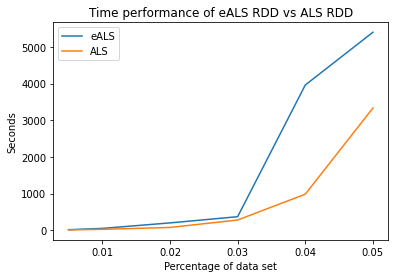

In [84]:
sns.lineplot(x=percentage_data, y=time_perf_eALS_rdd)
sns.lineplot(x=percentage_data, y=time_perf_ALS_rdd)
plt.title('Time performance of eALS RDD vs ALS RDD')
plt.ylabel('Seconds')
plt.xlabel('Percentage of data set')
plt.legend(('eALS', 'ALS'))
plt.savefig('graphs/time_eALS_ALS.png')
plt.show()

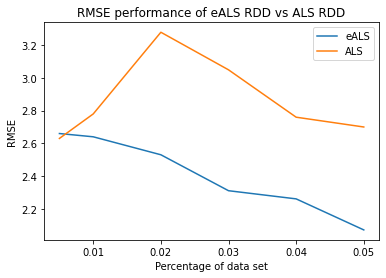

In [85]:
sns.lineplot(x=percentage_data, y=score_perf_eALS_rdd)
sns.lineplot(x=percentage_data, y=score_perf_ALS_rdd)
plt.title('RMSE performance of eALS RDD vs ALS RDD')
plt.ylabel('RMSE')
plt.xlabel('Percentage of data set')
plt.legend(('eALS', 'ALS'))
plt.savefig('graphs/RMSE_eALS_ALS.png')
plt.show()